## import os 

In [69]:
os.listdir()

['train.csv',
 'DataCleaning.ipynb',
 'PA_201605-2012001更新R6(20190509).xlsx',
 'tag盤點表.xlsx',
 'xgboost.ipynb',
 'train_FeatureSelected.csv',
 'feature select.ipynb',
 'tpot_pa_pipeline.py',
 'TPOT.ipynb',
 'cnn-time-stack.ipynb',
 '.ipynb_checkpoints']

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

# load

In [71]:
df = pd.read_csv('train_FeatureSelected.csv',index_col = 0,parse_dates = True)
print(df.shape)
df.head()

(122775, 15)


,MLPAP_TI-0706B15,MLPAP_TI-0706B21,MLPAP_TI-0716A03,MLPAP_TI-0716A05,MLPAP_TJR-0720A1.PV,MLPAP_TJR-0720B2.PV,MLPAP_TJR-0762A1.PV,MLPAP_TI-0706B01,MLPAP_TRC-0610.PV,MLPAP_TIC-1721.PV,MLPAP_TRC-1734.PV,MLPAP_FR-0755.PV,MLPAP_TIC-0757.PV,MLPAP_V125-PHD,target
0,0.436520,0.527857,2.885848,0.448321,0.677295,0.881300,0.796872,0.633992,3.036852,3.099501,0.608934,-2.619894,-1.015438,-0.088287,0.914125
1,0.436520,0.527857,2.885848,0.448321,0.677122,0.881648,0.797089,0.633992,2.864041,3.272350,0.447358,-2.614712,-0.982340,-0.088287,0.919765
2,0.436830,0.527857,2.885848,0.448321,0.677619,0.881571,0.796987,0.633992,3.006620,3.596289,-0.634915,-2.617016,-0.975999,-0.088287,0.926346
3,0.411821,0.395807,2.856863,0.468480,0.641630,0.853312,0.763786,0.601863,1.710665,3.361869,0.769126,-2.612469,-0.840360,-0.088287,0.906781
4,0.412131,0.395807,2.882331,0.468480,0.642077,0.853810,0.764300,0.603356,1.822449,3.029603,0.528846,-2.620588,-0.868595,-0.088287,0.926688


# scale

In [72]:
#from sklearn.preprocessing import MinMaxScaler

#x_col = df.drop('target',axis=1).columns.tolist()
#y_col = 'target'

#sc = MinMaxScaler()
#df[x_col] = sc.fit_transform(df[x_col])

#df.head()

# stack

In [74]:
step = 15
X_lst,y_lst = [],[]
x_col = df.drop('target',axis=1).columns.tolist()
y_col = 'target'

In [75]:
for i in tqdm(range(0,len(df)-step)):
    X_lst.append(df.iloc[i:i+step][x_col])
    y_lst.append(df.iloc[i+step][y_col])

# Visualization

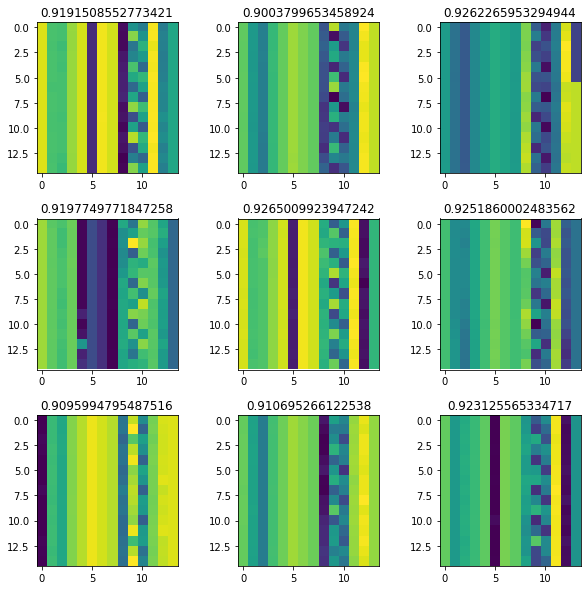

In [76]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace =0.3, hspace =0.3)
for i in range(0,9):
    plt.subplot(330 + (i+1))
    idx = np.random.randint(0,len(X_lst))
    plt.imshow(X_lst[idx])
    plt.title(y_lst[idx])

# split

In [77]:
from sklearn.model_selection import train_test_split

# reshape
X = np.array([i.values for i in X_lst])
X = X.reshape(-1,step,len(x_col),1)
y = np.array([i for i in y_lst])

# split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 7)
X_val, X_test ,y_val ,y_test = train_test_split(X_test, y_test, test_size=0.5, random_state = 7)

print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(85932, 15, 14, 1) (85932,)
(18414, 15, 14, 1) (18414,)
(18414, 15, 14, 1) (18414,)


# Model

In [78]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Lambda, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, AvgPool2D
from keras.optimizers import Adam
import warnings;warnings.simplefilter('ignore')

In [79]:
model = Sequential()

model.add(Conv2D(filters=6, kernel_size=(2,2), padding='same', activation='relu', input_shape=X[0].shape))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=16, kernel_size=(2,2), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 15, 14, 6)         30        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 6)           0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 16)          400       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 144)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 120)               17400     
_________________________________________________________________
dense_8 (Dense)              (None, 84)                10164     
__________

In [80]:
model.compile(optimizer=Adam(lr=0.0001), loss="mse", metrics=["mse"])

In [81]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss',min_delta=0,patience=10,mode='min')

# fit

In [82]:
history = model.fit(X_train,y_train,
                    batch_size = 256,
                    epochs = 100,
                    validation_data = (X_val,y_val),
                    verbose = 1,
                    callbacks = [es])

Train on 85932 samples, validate on 18414 samples
Epoch 1/100
85932/85932 [==============================] - 2s 21us/step - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 2/100
85932/85932 [==============================] - 1s 17us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 3/100
85932/85932 [==============================] - 1s 17us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 4/100
85932/85932 [==============================] - 1s 17us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 5/100
85932/85932 [==============================] - 1s 17us/step - loss: 9.8662e-04 - mean_squared_error: 9.8662e-04 - val_loss: 8.6798e-04 - val_mean_squared_error: 8.6798e-04
Epoch 6/100
85932/85932 [==============================] - 1s 17us/step - loss: 7.7195e-04 - m

85932/85932 [==============================] - 1s 17us/step - loss: 8.7072e-05 - mean_squared_error: 8.7072e-05 - val_loss: 9.4102e-05 - val_mean_squared_error: 9.4102e-05
Epoch 46/100
85932/85932 [==============================] - 1s 17us/step - loss: 8.3278e-05 - mean_squared_error: 8.3278e-05 - val_loss: 9.2483e-05 - val_mean_squared_error: 9.2483e-05
Epoch 47/100
85932/85932 [==============================] - 1s 17us/step - loss: 8.3368e-05 - mean_squared_error: 8.3368e-05 - val_loss: 9.3045e-05 - val_mean_squared_error: 9.3045e-05
Epoch 48/100
85932/85932 [==============================] - 1s 16us/step - loss: 8.0450e-05 - mean_squared_error: 8.0450e-05 - val_loss: 1.0001e-04 - val_mean_squared_error: 1.0001e-04
Epoch 49/100
85932/85932 [==============================] - 1s 17us/step - loss: 8.1496e-05 - mean_squared_error: 8.1496e-05 - val_loss: 1.0105e-04 - val_mean_squared_error: 1.0105e-04
Epoch 50/100
85932/85932 [==============================] - 1s 17us/step - loss: 8.1351e

85932/85932 [==============================] - 1s 17us/step - loss: 6.3329e-05 - mean_squared_error: 6.3329e-05 - val_loss: 7.3400e-05 - val_mean_squared_error: 7.3400e-05
Epoch 90/100
85932/85932 [==============================] - 1s 17us/step - loss: 6.4447e-05 - mean_squared_error: 6.4447e-05 - val_loss: 7.6495e-05 - val_mean_squared_error: 7.6495e-05
Epoch 91/100
85932/85932 [==============================] - 1s 17us/step - loss: 6.3673e-05 - mean_squared_error: 6.3673e-05 - val_loss: 7.3948e-05 - val_mean_squared_error: 7.3948e-05
Epoch 92/100
85932/85932 [==============================] - 1s 17us/step - loss: 6.2901e-05 - mean_squared_error: 6.2901e-05 - val_loss: 6.8493e-05 - val_mean_squared_error: 6.8493e-05
Epoch 93/100
85932/85932 [==============================] - 1s 17us/step - loss: 6.1426e-05 - mean_squared_error: 6.1426e-05 - val_loss: 6.8334e-05 - val_mean_squared_error: 6.8334e-05
Epoch 94/100
85932/85932 [==============================] - 1s 16us/step - loss: 6.3222e

# eval

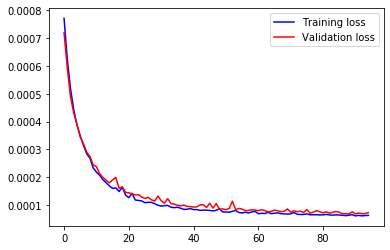

In [87]:
n = 5
plt.plot(history.history['loss'][n:], color='b', label="Training loss")
plt.plot(history.history['val_loss'][n:], color='r', label="Validation loss")
plt.legend()

In [88]:
from sklearn.metrics import r2_score,mean_squared_error

y_pred = model.predict(X_test).ravel()
print(round(r2_score(y_test,y_pred),4))
print(round(mean_squared_error(y_test,y_pred),4))

0.2565
0.0001


In [89]:
print(round(df['target'].std(),4))

0.0096
